<a href="https://colab.research.google.com/github/chengulatj/Chicago-Rideshare-Event-Study/blob/main/TNP_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary dependecies
!pip -q install pandas sodapy python-dateutil pyarrow

In [4]:
#import all the dependencies
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sodapy import Socrata
from requests.exceptions import ReadTimeout, ConnectionError

# setup the API
DOMAIN  = "data.cityofchicago.org"
DATASET = "n26f-ihde"   # Transportation Network Providers - Trips (2023-2024)
APP_TOKEN = os.getenv("CHICAGO_APP_TOKEN", None)
client = Socrata(DOMAIN, APP_TOKEN, timeout=600)

# Filter the data to what we just need
CA = 33  # The soldier field area
YEAR = 2024
MONTHS = [5, 6, 8, 9]  # May, June, August, September
MONTHS_CSV = ",".join(str(m) for m in MONTHS)

WHERE_CA33 = f"(pickup_community_area = {CA} OR dropoff_community_area = {CA})"

# Keep trips if EITHER the start OR the end timestamp is in the target months of YEAR
WHERE_TIME = (
    "("
    f"(date_extract_y(trip_start_timestamp) = {YEAR} AND "
    f"  date_extract_m(trip_start_timestamp) IN ({MONTHS_CSV}))"
    " OR "
    f"(date_extract_y(trip_end_timestamp) = {YEAR} AND "
    f"  date_extract_m(trip_end_timestamp) IN ({MONTHS_CSV}))"
    ")"
)

WHERE_FINAL = f"{WHERE_CA33} AND ({WHERE_TIME})"

# Pagination
PAGE_SIZE = 50_000
rows, offset = [], 0

# Count for progress
try:
    total = int(client.get(DATASET, select="count(1)", where=WHERE_FINAL)[0]["count"])
    print(f"CA {CA} rows to fetch for {YEAR}-{{{', '.join(map(str, MONTHS))}}}: {total:,}")
except Exception:
    total = None
    print("Fetching CA 33 rows for selected months (total count unavailable)…")

# Paged fetch (stable :id ordering)
while True:
    try:
        batch = client.get(
            DATASET,
            where=WHERE_FINAL,
            limit=PAGE_SIZE,
            offset=offset,
            order=":id"
        )
    except (ReadTimeout, ConnectionError):
        time.sleep(1.0)
        batch = client.get(
            DATASET,
            where=WHERE_FINAL,
            limit=PAGE_SIZE,
            offset=offset,
            order=":id"
        )

    if not batch:
        break

    rows.extend(batch)
    offset += PAGE_SIZE

    if total:
        print(f"  fetched {min(offset, total):,}/{total:,}…")
    else:
        print(f"  fetched {offset:,} so far…")

#DataFrame
df = pd.DataFrame.from_records(rows)

# Sanity check: enforce CA=33 client-side
for ca_col in ("pickup_community_area", "dropoff_community_area"):
    if ca_col in df.columns:
        df[ca_col] = pd.to_numeric(df[ca_col], errors="coerce")
m_either = df["pickup_community_area"].eq(CA) | df["dropoff_community_area"].eq(CA)
if (~m_either).any():
    df = df.loc[m_either].copy()

# Parse timestamps as local wall-clock (naive)
# Socrata field type is "Floating Timestamp" (local without timezone). Parse as naive.
for col in ("trip_start_timestamp", "trip_end_timestamp"):
    if col in df.columns:
        s = pd.to_datetime(df[col], errors="coerce")  # DO NOT set utc=True
        # If anything is tz-aware (shouldn't be), drop tz without shifting wall clock.
        if getattr(s.dt, "tz", None) is not None:
            s = s.dt.tz_localize(None)
        df[col] = s

#Numerics & derived
num_cols = [
    "trip_seconds","trip_miles",
    "percent_time_chicago","percent_distance_chicago",
    "fare","tip","additional_charges","trip_total","trips_pooled",
    "pickup_community_area","dropoff_community_area",
    "pickup_centroid_latitude","pickup_centroid_longitude",
    "dropoff_centroid_latitude","dropoff_centroid_longitude"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if {"trip_miles","trip_seconds"}.issubset(df.columns):
    df["mph"] = 3600 * df["trip_miles"] / df["trip_seconds"]
if {"trip_total","trip_miles"}.issubset(df.columns):
    df["fare_per_mile"] = df["trip_total"] / df["trip_miles"]

print(f"\nRows fetched (CA {CA}, {YEAR}-{{{', '.join(map(str, MONTHS))}}}): {len(df):,} | Columns: {len(df.columns)}")


Fetching CA 33 rows for selected months (total count unavailable)…
  fetched 50,000 so far…
  fetched 100,000 so far…
  fetched 150,000 so far…
  fetched 200,000 so far…
  fetched 250,000 so far…
  fetched 300,000 so far…
  fetched 350,000 so far…
  fetched 400,000 so far…
  fetched 450,000 so far…
  fetched 500,000 so far…
  fetched 550,000 so far…
  fetched 600,000 so far…
  fetched 650,000 so far…
  fetched 700,000 so far…
  fetched 750,000 so far…
  fetched 800,000 so far…
  fetched 850,000 so far…
  fetched 900,000 so far…
  fetched 950,000 so far…
  fetched 1,000,000 so far…
  fetched 1,050,000 so far…
  fetched 1,100,000 so far…
  fetched 1,150,000 so far…
  fetched 1,200,000 so far…
  fetched 1,250,000 so far…
  fetched 1,300,000 so far…
  fetched 1,350,000 so far…

Rows fetched (CA 33, 2024-{5, 6, 8, 9}): 1,325,472 | Columns: 26


In [26]:
# Events
EVENTS = [
    {"name": "2024-08-31 Fire v Inter Miami (Soldier Field)", "kick": pd.Timestamp("2024-08-31 19:30")},
    {"name": "2024-05-31 Mexico v Bolivia (Soldier Field)",   "kick": pd.Timestamp("2024-05-31 20:00")},
]

# Segment timing
PRE_H  = 3   # hours before kickoff included in arrivals
POST_H = 1.5   # hours after final whistle (match-end)
REG_MIN, HALFTIME_MIN, BUFFER_MIN = 90, 15, 5
GAME_MIN = REG_MIN + HALFTIME_MIN + BUFFER_MIN  # ~110 min
LATE_ARRIVAL_MIN = 20   # allow arrivals up to 20 min after kickoff
EARLY_DEPART_MIN = 20   # allow departures up to 20 min before final whistle
PAD_MIN = 15            # absorb dataset's 15-min rounding

def flexible_bounds(kick_ts: pd.Timestamp,
                    pre_h=PRE_H, post_h=POST_H,
                    game_min=GAME_MIN,
                    late_arrival_min=LATE_ARRIVAL_MIN,
                    early_depart_min=EARLY_DEPART_MIN,
                    pad_min=PAD_MIN):
    # ensure naive (no tz)
    if getattr(kick_ts, "tzinfo", None) is not None:
        kick_ts = kick_ts.tz_localize(None)

    pre_start  = kick_ts - pd.Timedelta(hours=pre_h) - pd.Timedelta(minutes=pad_min)
    pre_end    = kick_ts + pd.Timedelta(minutes=late_arrival_min + pad_min)

    post_start = (kick_ts + pd.Timedelta(minutes=game_min)
                            - pd.Timedelta(minutes=early_depart_min + pad_min))
    post_end   = (kick_ts + pd.Timedelta(minutes=game_min)
                            + pd.Timedelta(hours=post_h, minutes=pad_min))

    if pre_end >= post_start:
        post_start = pre_end + pd.Timedelta(minutes=1)
    return pre_start, pre_end, post_start, post_end

def build_segment_baselines(kick_ts: pd.Timestamp, segment: str, weeks: int = 4):
    """Return list of (start_ts, end_ts) windows for ±1..weeks weeks (same weekday/clock)."""
    pre_start, pre_end, post_start, post_end = flexible_bounds(kick_ts)
    s0, e0 = (pre_start, pre_end) if segment == "pre" else (post_start, post_end)
    wins = []
    for w in range(1, weeks+1):
        for sign in (-1, +1):
            delta = pd.Timedelta(days=7*w*sign)
            wins.append((s0 + delta, e0 + delta))
    return wins

#  Segment slicers (operate on in-memory df; CA already filtered server-side)
def slice_arrivals_event(df_in: pd.DataFrame, kick_ts: pd.Timestamp) -> pd.DataFrame:
    """Arrivals: drop-offs in CA with END times in pre window (incl. late arrivals)."""
    pre_start, pre_end, _, _ = flexible_bounds(kick_ts)
    drop_ca = pd.to_numeric(df_in.get("dropoff_community_area"), errors="coerce")
    mask = (drop_ca == CA) & df_in["trip_end_timestamp"].between(pre_start, pre_end, inclusive="both")
    out = df_in.loc[mask].copy()
    out["segment"] = "arrivals_pre"
    out["segment_start_local"] = pre_start
    out["segment_end_local"] = pre_end
    return out

def slice_departures_event(df_in: pd.DataFrame, kick_ts: pd.Timestamp) -> pd.DataFrame:
    """Departures: pickups in CA with START times in post window (incl. early departures)."""
    _, _, post_start, post_end = flexible_bounds(kick_ts)
    pick_ca = pd.to_numeric(df_in.get("pickup_community_area"), errors="coerce")
    mask = (pick_ca == CA) & df_in["trip_start_timestamp"].between(post_start, post_end, inclusive="both")
    out = df_in.loc[mask].copy()
    out["segment"] = "departures_post"
    out["segment_start_local"] = post_start
    out["segment_end_local"] = post_end
    return out

def slice_arrivals_baselines(df_in: pd.DataFrame, kick_ts: pd.Timestamp, weeks=4) -> pd.DataFrame:
    frames = []
    drop_ca = pd.to_numeric(df_in.get("dropoff_community_area"), errors="coerce")
    for s, e in build_segment_baselines(kick_ts, "pre", weeks=weeks):
        m = (drop_ca == CA) & df_in["trip_end_timestamp"].between(s, e, inclusive="both")
        part = df_in.loc[m].copy()
        if not part.empty:
            part["segment"] = "arrivals_pre"
            part["segment_start_local"] = s
            part["segment_end_local"] = e
            frames.append(part)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def slice_departures_baselines(df_in: pd.DataFrame, kick_ts: pd.Timestamp, weeks=4) -> pd.DataFrame:
    frames = []
    pick_ca = pd.to_numeric(df_in.get("pickup_community_area"), errors="coerce")
    for s, e in build_segment_baselines(kick_ts, "post", weeks=weeks):
        m = (pick_ca == CA) & df_in["trip_start_timestamp"].between(s, e, inclusive="both")
        part = df_in.loc[m].copy()
        if not part.empty:
            part["segment"] = "departures_post"
            part["segment_start_local"] = s
            part["segment_end_local"] = e
            frames.append(part)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# Build segments for each event
seg_event_frames, seg_baseline_frames = [], []

for ev in EVENTS:
    print(f"\n--- Segments for {ev['name']} ---")
    dfe_arr = slice_arrivals_event(df, ev["kick"])
    if not dfe_arr.empty:
        dfe_arr["event_name"] = ev["name"]
        dfe_arr["window_type"] = "event"
        seg_event_frames.append(dfe_arr)
        print(f"  Arrivals (event) rows: {len(dfe_arr):,}")
    dfb_arr = slice_arrivals_baselines(df, ev["kick"], weeks=4)
    if not dfb_arr.empty:
        dfb_arr["event_name"] = ev["name"]
        dfb_arr["window_type"] = "baseline"
        seg_baseline_frames.append(dfb_arr)
        print(f"  Arrivals (baseline) rows: {len(dfb_arr):,}")

    dfe_dep = slice_departures_event(df, ev["kick"])
    if not dfe_dep.empty:
        dfe_dep["event_name"] = ev["name"]
        dfe_dep["window_type"] = "event"
        seg_event_frames.append(dfe_dep)
        print(f"  Departures (event) rows: {len(dfe_dep):,}")
    dfb_dep = slice_departures_baselines(df, ev["kick"], weeks=4)
    if not dfb_dep.empty:
        dfb_dep["event_name"] = ev["name"]
        dfb_dep["window_type"] = "baseline"
        seg_baseline_frames.append(dfb_dep)
        print(f"  Departures (baseline) rows: {len(dfb_dep):,}")

df_seg_events   = pd.concat(seg_event_frames, ignore_index=True) if seg_event_frames else pd.DataFrame()
df_seg_baseline = pd.concat(seg_baseline_frames, ignore_index=True) if seg_baseline_frames else pd.DataFrame()

print(f"\nSegment rows → events: {len(df_seg_events):,} | baselines: {len(df_seg_baseline):,}")


--- Segments for 2024-08-31 Fire v Inter Miami (Soldier Field) ---
  Arrivals (event) rows: 3,003
  Arrivals (baseline) rows: 16,382
  Departures (event) rows: 1,064
  Departures (baseline) rows: 6,028

--- Segments for 2024-05-31 Mexico v Bolivia (Soldier Field) ---
  Arrivals (event) rows: 2,744
  Arrivals (baseline) rows: 15,482
  Departures (event) rows: 1,195
  Departures (baseline) rows: 6,324

Segment rows → events: 8,006 | baselines: 44,216


In [27]:
# Segment summaries (keep which_event / which_baseline)
def summarize_seg(df_in: pd.DataFrame, label: str) -> pd.DataFrame:
    if df_in.empty:
        return pd.DataFrame(columns=[
            "event_name","segment","rows","med_fare_per_mile","p75_fare_per_mile","med_mph","p25_mph","which"
        ])
    g = (df_in.groupby(["event_name","segment"], as_index=False)
               .agg(rows=("trip_id","count"),
                    med_fare_per_mile=("fare_per_mile","median"),
                    p75_fare_per_mile=("fare_per_mile", lambda x: x.quantile(0.75)),
                    med_mph=("mph","median"),
                    p25_mph=("mph", lambda x: x.quantile(0.25))))
    g["which"] = label
    return g

ev_seg = summarize_seg(df_seg_events, "event")
bl_seg = summarize_seg(df_seg_baseline, "baseline")

summary_seg = ev_seg.merge(
    bl_seg,
    on=["event_name","segment"],
    suffixes=("_event","_baseline"),
    how="left"
)

# Baseline window sizes per segment (avoid tiny multipliers)
bl_win_seg = (
    df_seg_baseline.groupby(["event_name","segment","segment_start_local"], as_index=False)
                   .agg(rows_baseline_win=("trip_id","count"))
)
bl_agg_seg = (
    bl_win_seg.groupby(["event_name","segment"], as_index=False)
              .agg(rows_baseline_avg_win=("rows_baseline_win","mean"),
                   rows_baseline_median_win=("rows_baseline_win","median"),
                   n_baseline_windows=("rows_baseline_win","size"))
)
summary_seg = summary_seg.merge(bl_agg_seg, on=["event_name","segment"], how="left")

# Indices: multiplier vs AVG baseline window + percent lift
summary_seg["trips_multiplier"] = summary_seg["rows_event"] / summary_seg["rows_baseline_avg_win"]
summary_seg["trip_lift_pct_vs_avg_window"] = (summary_seg["trips_multiplier"] - 1.0) * 100.0

# Price & speed indices
summary_seg["surge_index_fare_per_mile_med"] = (
    summary_seg["med_fare_per_mile_event"] / summary_seg["med_fare_per_mile_baseline"]
)
summary_seg["mph_change_med"] = summary_seg["med_mph_event"] - summary_seg["med_mph_baseline"]

# Optional robust (median-window) versions
summary_seg["trips_multiplier_vs_median_window"] = summary_seg["rows_event"] / summary_seg["rows_baseline_median_win"]
summary_seg["trip_lift_pct_vs_median_window"] = (summary_seg["trips_multiplier_vs_median_window"] - 1.0) * 100.0

print("\n Segment summary (arrivals_pre / departures_post)")
pd.set_option("display.max_columns", None)
display(summary_seg)


 Segment summary (arrivals_pre / departures_post)


,event_name,segment,rows_event,med_fare_per_mile_event,p75_fare_per_mile_event,med_mph_event,p25_mph_event,which_event,rows_baseline,med_fare_per_mile_baseline,p75_fare_per_mile_baseline,med_mph_baseline,p25_mph_baseline,which_baseline,rows_baseline_avg_win,rows_baseline_median_win,n_baseline_windows,trips_multiplier,trip_lift_pct_vs_avg_window,surge_index_fare_per_mile_med,mph_change_med,trips_multiplier_vs_median_window,trip_lift_pct_vs_median_window
0,2024-05-31 Mexico v Bolivia (Soldier Field),arrivals_pre,2744,6.955183,10.505395,9.611045,6.944401,event,15482,6.179813,10.299895,12.622535,9.113138,baseline,1935.25,1503.0,8,1.417905,41.790466,1.125468,-3.011490,1.825682,82.568197
1,2024-05-31 Mexico v Bolivia (Soldier Field),departures_post,1195,6.295556,9.520296,12.946415,10.433729,event,6324,5.209765,8.092727,16.166438,12.218788,baseline,790.50,839.0,8,1.511701,51.170145,1.208415,-3.220023,1.424315,42.431466
2,2024-08-31 Fire v Inter Miami (Soldier Field),arrivals_pre,3003,5.964286,9.542224,11.660057,8.429995,event,16382,5.483108,8.299827,13.992997,10.452684,baseline,2047.75,1699.0,8,1.466488,46.648761,1.087756,-2.332940,1.767510,76.751030
3,2024-08-31 Fire v Inter Miami (Soldier Field),departures_post,1064,6.411925,9.853383,11.761389,8.637076,event,6028,5.175115,7.751758,14.887090,11.440611,baseline,753.50,734.5,8,1.412077,41.207697,1.238992,-3.125700,1.448604,44.860449


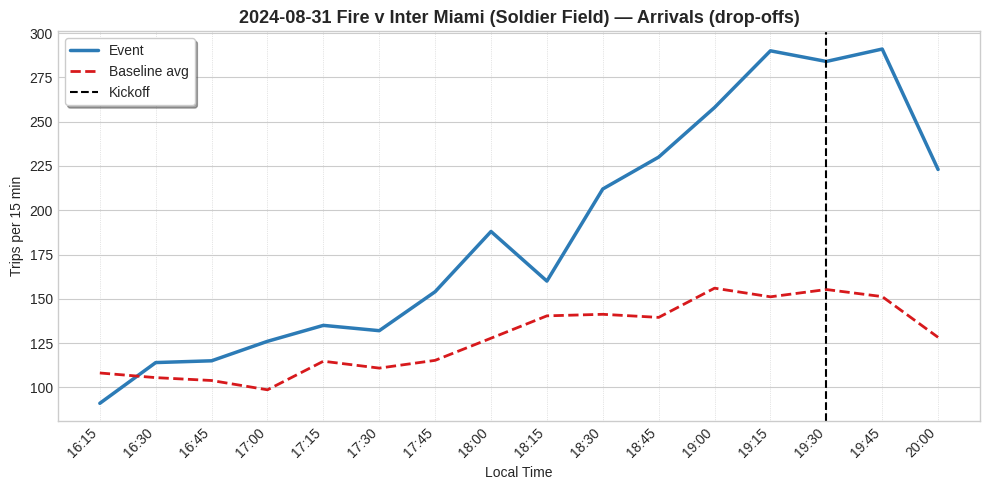

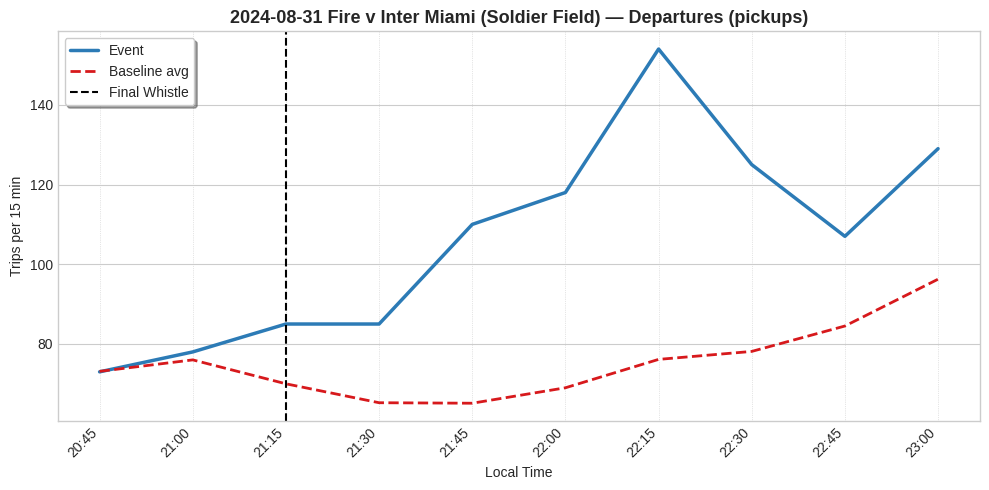

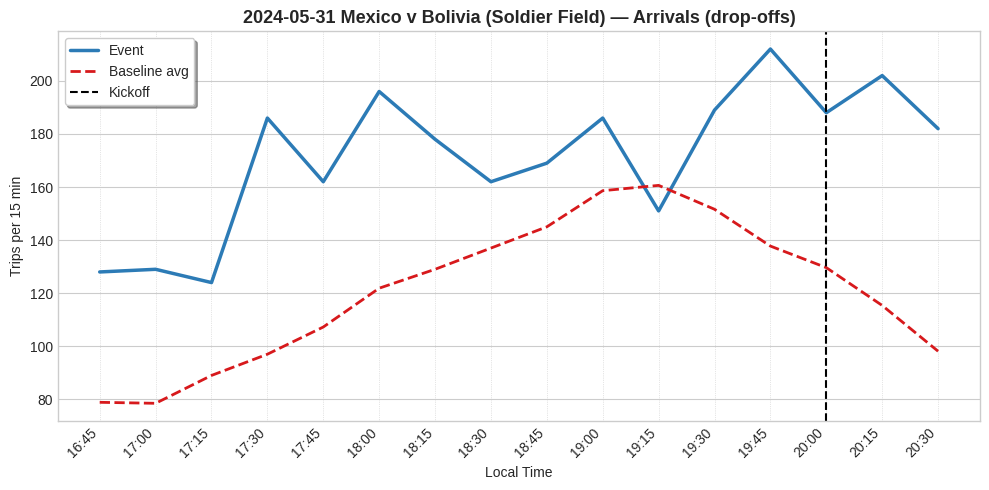

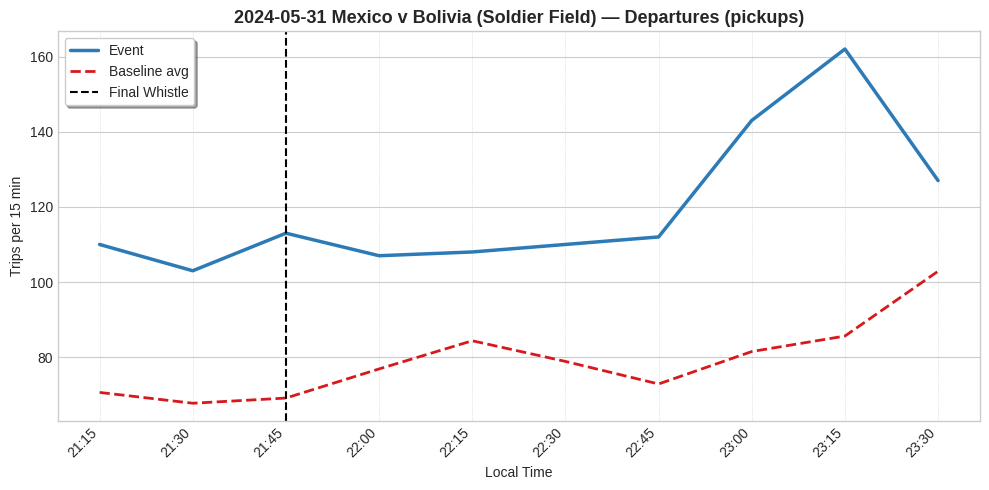

In [46]:
#  Visualizations

import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")  # modern look

# Custom palette
event_color = "#2c7bb6"     # blue
baseline_color = "#d7191c"  # red
marker_color = "black"
arrivals_box = "#31a354"    # green shade
departures_box = "#756bb1"  # purple shade

# 1) Timestamp x-axis curves (15-min bins), event vs baseline avg
def build_curves_timestamp_x(event_name: str, segment: str):
    tcol = "trip_end_timestamp" if segment == "arrivals_pre" else "trip_start_timestamp"

    ev = df_seg_events[(df_seg_events["event_name"] == event_name) &
                       (df_seg_events["segment"] == segment)].copy()
    if ev.empty:
        return None, None, None

    seg_start = ev["segment_start_local"].iloc[0]
    ev["ts"] = ev[tcol].dt.floor("15min")
    ev_curve = (ev.groupby("ts", as_index=False)
                  .agg(trips=("trip_id","count"))
                  .sort_values("ts"))

    bl = df_seg_baseline[(df_seg_baseline["event_name"] == event_name) &
                         (df_seg_baseline["segment"] == segment)].copy()
    if bl.empty:
        bl_curve_on_event = None
    else:
        bl["rel_bin"] = ((bl[tcol].dt.floor("15min") - bl["segment_start_local"])
                           .dt.total_seconds() // 900).astype(int)
        per_win = (bl.groupby(["segment_start_local","rel_bin"], as_index=False)
                     .agg(trips=("trip_id","count")))
        bl_avg = (per_win.groupby("rel_bin", as_index=False)
                        .agg(trips_avg=("trips","mean"))
                        .sort_values("rel_bin"))
        bl_avg["ts"] = bl_avg["rel_bin"].apply(lambda k: seg_start + pd.Timedelta(minutes=15*int(k)))
        bl_curve_on_event = bl_avg[["ts","trips_avg"]]

    return ev_curve, bl_curve_on_event, seg_start

def stylize_time_axis(ax, title, xlab, ylab):
    ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.set_xlabel(xlab); ax.set_ylabel(ylab); ax.set_title(title, fontsize=13, weight="bold")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.grid(True, axis="x", linewidth=0.5, linestyle=":")

# Plot both segments for each event with shaded windows
for ev in EVENTS:
    evname, kickoff = ev["name"], ev["kick"]

    # Arrivals
    ev_curve, bl_curve, seg_start = build_curves_timestamp_x(evname, "arrivals_pre")
    if ev_curve is not None:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(ev_curve["ts"], ev_curve["trips"], label="Event",
                color=event_color, linewidth=2.5)
        if bl_curve is not None:
            ax.plot(bl_curve["ts"], bl_curve["trips_avg"], label="Baseline avg",
                    color=baseline_color, linestyle="--", linewidth=2)
        ax.axvline(kickoff.floor("15min"), linestyle="--", color=marker_color, linewidth=1.5, label="Kickoff")
        stylize_time_axis(ax,
            title=f"{evname} — Arrivals (drop-offs)",
            xlab="Local Time",
            ylab="Trips per 15 min"
        )
        ax.legend(frameon=True, fancybox=True, shadow=True, loc="upper left")
        plt.tight_layout(); plt.show()

    # Departures
    ev_curve, bl_curve, seg_start = build_curves_timestamp_x(evname, "departures_post")
    if ev_curve is not None:
        final_whistle = kickoff + pd.Timedelta(minutes=GAME_MIN)
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(ev_curve["ts"], ev_curve["trips"], label="Event",
                color=event_color, linewidth=2.5)
        if bl_curve is not None:
            ax.plot(bl_curve["ts"], bl_curve["trips_avg"], label="Baseline avg",
                    color=baseline_color, linestyle="--", linewidth=2)
        ax.axvline(final_whistle.floor("15min"), linestyle="--", color=marker_color, linewidth=1.5, label="Final Whistle")
        stylize_time_axis(ax,
            title=f"{evname} — Departures (pickups)",
            xlab="Local Time",
            ylab="Trips per 15 min"
        )
        ax.legend(frameon=True, fancybox=True, shadow=True, loc="upper left")
        plt.tight_layout(); plt.show()


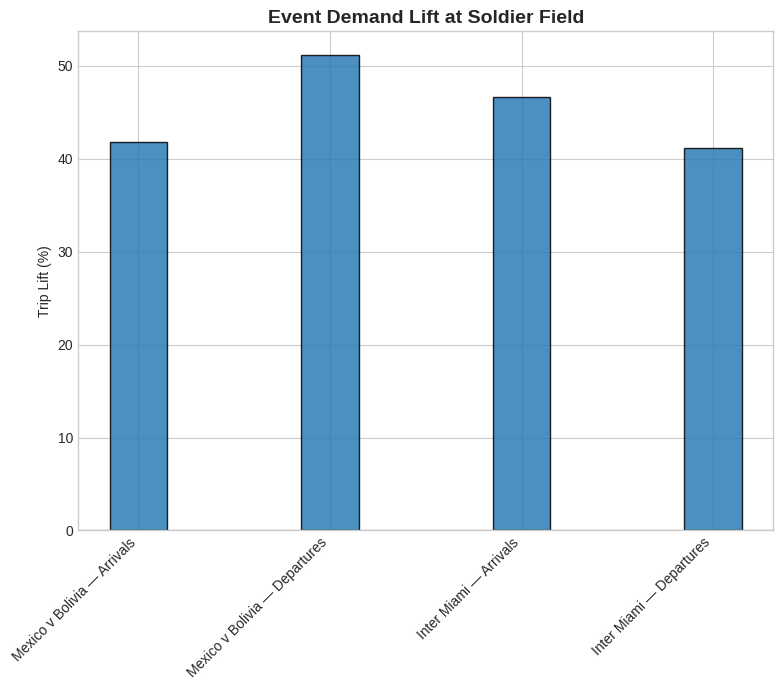

In [44]:
# Trip lift % bar chart (thinner bars, custom labels)
if not summary_seg.empty:
    # Custom labels for (event_name, segment)
    custom_labels = {
        ("2024-08-31 Fire v Inter Miami (Soldier Field)", "arrivals_pre"): "Inter Miami — Arrivals",
        ("2024-08-31 Fire v Inter Miami (Soldier Field)", "departures_post"): "Inter Miami — Departures",
        ("2024-05-31 Mexico v Bolivia (Soldier Field)", "arrivals_pre"): "Mexico v Bolivia — Arrivals",
        ("2024-05-31 Mexico v Bolivia (Soldier Field)", "departures_post"): "Mexico v Bolivia — Departures",
    }

    # Build plot dataframe
    plot_df = summary_seg[["event_name","segment","trip_lift_pct_vs_avg_window"]].copy()
    plot_df["label"] = plot_df.apply(
        lambda row: custom_labels.get((row["event_name"], row["segment"])), axis=1
    )

    # Plot
    x = np.arange(len(plot_df))
    y = plot_df["trip_lift_pct_vs_avg_window"].values

    fig, ax = plt.subplots(figsize=(8,7))
    bars = ax.bar(x, y, width=0.3, color=event_color, alpha=0.85, edgecolor="black")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df["label"], rotation=45, ha="right")
    ax.set_ylabel("Trip Lift (%)")
    ax.set_title("Event Demand Lift at Soldier Field", fontsize=14, weight="bold")
    ax.axhline(0, color="black", linewidth=0.8)

    plt.tight_layout()
    plt.show()


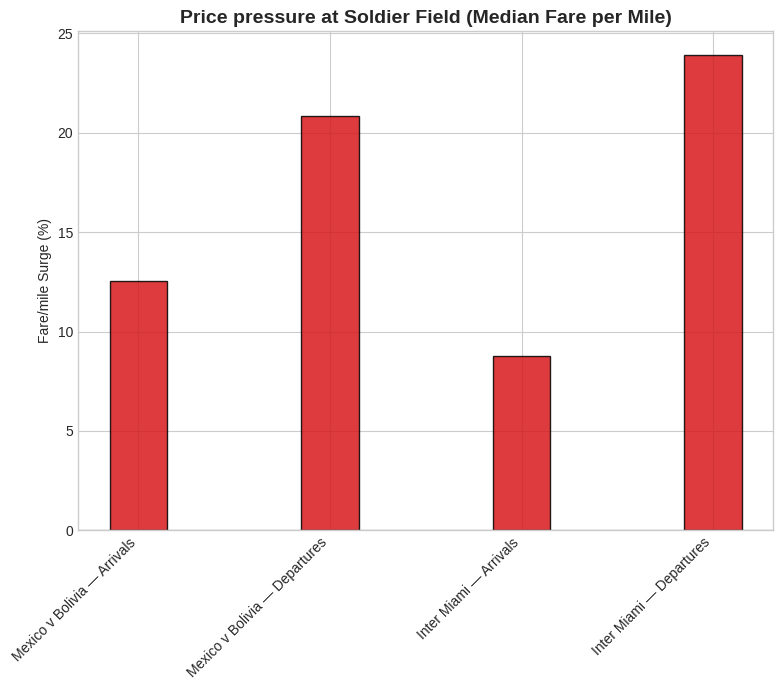

In [45]:
# Fare-per-mile surge % bar chart (thinner bars, custom labels)
if not summary_seg.empty:
    # Custom labels for (event_name, segment)
    custom_labels = {
        ("2024-08-31 Fire v Inter Miami (Soldier Field)", "arrivals_pre"): "Inter Miami — Arrivals",
        ("2024-08-31 Fire v Inter Miami (Soldier Field)", "departures_post"): "Inter Miami — Departures",
        ("2024-05-31 Mexico v Bolivia (Soldier Field)", "arrivals_pre"): "Mexico v Bolivia — Arrivals",
        ("2024-05-31 Mexico v Bolivia (Soldier Field)", "departures_post"): "Mexico v Bolivia — Departures",
    }

    # Build plot dataframe
    plot_df2 = summary_seg[["event_name","segment","surge_index_fare_per_mile_med"]].copy()
    plot_df2["surge_pct"] = (plot_df2["surge_index_fare_per_mile_med"] - 1.0) * 100.0
    plot_df2["label"] = plot_df2.apply(
        lambda row: custom_labels.get((row["event_name"], row["segment"])), axis=1
    )

    # Plot
    x = np.arange(len(plot_df2))
    y = plot_df2["surge_pct"].values

    fig, ax = plt.subplots(figsize=(8,7))
    bars = ax.bar(x, y, width=0.3, color=baseline_color, alpha=0.85, edgecolor="black")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df2["label"], rotation=45, ha="right")
    ax.set_ylabel("Fare/mile Surge (%)")
    ax.set_title("Price pressure at Soldier Field (Median Fare per Mile)", fontsize=14, weight="bold")
    ax.axhline(0, color="black", linewidth=0.8)

    plt.tight_layout()
    plt.show()
